In [ ]:
# NBA Betting Model Analysis & Visualization

#This notebook provides comprehensive analysis and visualization of the NBA betting model data.

#**Current Section**: Data Loading & Overview  
#**Last Updated**: August 2025


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import sqlite3
from datetime import datetime, date
import yaml

# Set up plotting styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set up paths
PROJECT_ROOT = Path('.').absolute().parent
DATA_PATH = PROJECT_ROOT / 'data'
PROCESSED_PATH = DATA_PATH / 'processed'
RAW_PATH = DATA_PATH / 'raw'

print("🏀 NBA Betting Analysis Setup Complete")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Path: {DATA_PATH}")
print("="*50)


🏀 NBA Betting Analysis Setup Complete
Project Root: /Users/yirgareminick/Documents/NBA-Betting-Model
Data Path: /Users/yirgareminick/Documents/NBA-Betting-Model/data


In [3]:
# Load processed features data
features_file = PROCESSED_PATH / 'nba_features.parquet'
if features_file.exists():
    features_df = pd.read_parquet(features_file)
    print(f"✅ Loaded processed features: {features_df.shape}")
else:
    print("❌ No processed features found")
    features_df = None

# Load recent games data (2024-2025 season)
games_file = PROCESSED_PATH / 'games_2024_2025.csv'
if games_file.exists():
    games_df = pd.read_csv(games_file)
    games_df['game_date'] = pd.to_datetime(games_df['game_date'])
    print(f"✅ Loaded 2024-2025 games: {games_df.shape}")
else:
    print("❌ No recent games data found")
    games_df = None

# Load historical games data (2020-2023)
historical_file = PROCESSED_PATH / 'games_2020_2023.csv'
if historical_file.exists():
    historical_df = pd.read_csv(historical_file)
    historical_df['game_date'] = pd.to_datetime(historical_df['game_date'])
    print(f"✅ Loaded historical games: {historical_df.shape}")
else:
    print("❌ No historical games data found")
    historical_df = None

# Check for performance database
performance_db = DATA_PATH / 'performance.db'
if performance_db.exists():
    print(f"✅ Found performance database: {performance_db}")
    performance_available = True
else:
    print("❌ No performance database found")
    performance_available = False

print("\n" + "="*50)
print("📊 Data Summary:")
if features_df is not None:
    print(f"• Features: {features_df.shape[0]:,} records, {features_df.shape[1]} features")
if games_df is not None:
    print(f"• Recent Games: {games_df.shape[0]:,} games (2024-2025)")
if historical_df is not None:
    print(f"• Historical Games: {historical_df.shape[0]:,} games (2020-2023)")
print(f"• Performance Tracking: {'Available' if performance_available else 'Not Available'}")
print("="*50)


✅ Loaded processed features: (9250, 18)
✅ Loaded 2024-2025 games: (65698, 55)
✅ Loaded historical games: (4626, 55)
✅ Found performance database: /Users/yirgareminick/Documents/NBA-Betting-Model/data/performance.db

📊 Data Summary:
• Features: 9,250 records, 18 features
• Recent Games: 65,698 games (2024-2025)
• Historical Games: 4,626 games (2020-2023)
• Performance Tracking: Available


In [12]:
# Explore features data structure
if features_df is not None:
    print("FEATURES DATA EXPLORATION")
    print("="*50)
    
    print("Dataset Info:")
    print(f"• Shape: {features_df.shape}")
    print(f"• Date Range: {features_df['game_date'].min()} to {features_df['game_date'].max()}")
    print(f"• Unique Teams: {features_df['team_name'].nunique()}")
    print(f"• Total Games: {features_df['game_id'].nunique()}")
    
    print("\nFeature Categories:")
    feature_cols = features_df.columns.tolist()
    
    # Categorize features
    rolling_features = [col for col in feature_cols if 'last_' in col]
    season_features = [col for col in feature_cols if 'season_' in col]
    basic_features = [col for col in feature_cols if col in ['game_id', 'game_date', 'team_name', 'opponent', 'venue', 'is_home', 'target_win']]
    other_features = [col for col in feature_cols if col not in rolling_features + season_features + basic_features]
    
    print(f"• Basic Info: {len(basic_features)} features")
    print(f"• Rolling Stats: {len(rolling_features)} features")
    print(f"• Season Stats: {len(season_features)} features") 
    print(f"• Other Features: {len(other_features)} features")
    
    print("\nSample Data:")
    display(features_df.head())
    
    print("\nTarget Variable Distribution:")
    win_rate = features_df['target_win'].mean()
    print(f"• Overall Win Rate: {win_rate:.1%}")
    if 'is_home' in features_df.columns:
        print(f"• Home Win Rate: {features_df[features_df['is_home']==1]['target_win'].mean():.1%}")
        print(f"• Away Win Rate: {features_df[features_df['is_home']==0]['target_win'].mean():.1%}")
else:
    print("❌ No features data available for exploration")


FEATURES DATA EXPLORATION
Dataset Info:
• Shape: (9250, 18)
• Date Range: 2020-01-01 to 2023-06-12
• Unique Teams: 34
• Total Games: 4624

Feature Categories:
• Basic Info: 7 features
• Rolling Stats: 6 features
• Season Stats: 3 features
• Other Features: 2 features

Sample Data:


,game_id,game_date,team_name,opponent,venue,is_home,target_win,avg_pts_last_10,avg_pts_allowed_last_10,avg_point_diff_last_10,win_pct_last_10,win_pct_last_5,avg_point_diff_last_5,rest_days,game_number_in_season,season_win_pct,season_avg_pts,season_avg_pts_allowed
0,21900517,2020-01-03,Atlanta Hawks,Boston Celtics,away,False,False,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,0.40625,116.09375,121.5
1,21900526,2020-01-04,Atlanta Hawks,Indiana Pacers,home,True,True,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,0.40625,116.09375,121.5
2,21900543,2020-01-06,Atlanta Hawks,Denver Nuggets,home,True,False,NaN,NaN,NaN,NaN,NaN,NaN,2,3.0,0.40625,116.09375,121.5
3,21900558,2020-01-08,Atlanta Hawks,Houston Rockets,home,True,False,NaN,NaN,NaN,NaN,NaN,NaN,2,4.0,0.40625,116.09375,121.5
4,21900567,2020-01-10,Atlanta Hawks,Washington Wizards,away,False,False,NaN,NaN,NaN,NaN,NaN,NaN,2,5.0,0.40625,116.09375,121.5



Target Variable Distribution:
• Overall Win Rate: 50.0%
• Home Win Rate: 55.3%
• Away Win Rate: 44.7%


FEATURE CORRELATION ANALYSIS
Analyzing correlations for 11 numeric features

TOP 15 FEATURES CORRELATED WITH WINS:
--------------------------------------------------
 1. season_win_pct                 +0.2912
 2. avg_point_diff_last_10         +0.1550
 3. season_avg_pts_allowed         -0.1516
 4. season_avg_pts                 +0.1409
 5. win_pct_last_10                +0.1374
 6. avg_point_diff_last_5          +0.1324
 7. win_pct_last_5                 +0.1149
 8. avg_pts_allowed_last_10        -0.0864
 9. avg_pts_last_10                +0.0853
10. rest_days                      +0.0086
11. game_number_in_season          -0.0011

BOTTOM 10 FEATURES CORRELATED WITH WINS:
--------------------------------------------------
 1. avg_point_diff_last_10         +0.1550
 2. season_avg_pts_allowed         -0.1516
 3. season_avg_pts                 +0.1409
 4. win_pct_last_10                +0.1374
 5. avg_point_diff_last_5          +0.1324
 6. win_pct_last_5                 +0.1149
 7. avg_pt

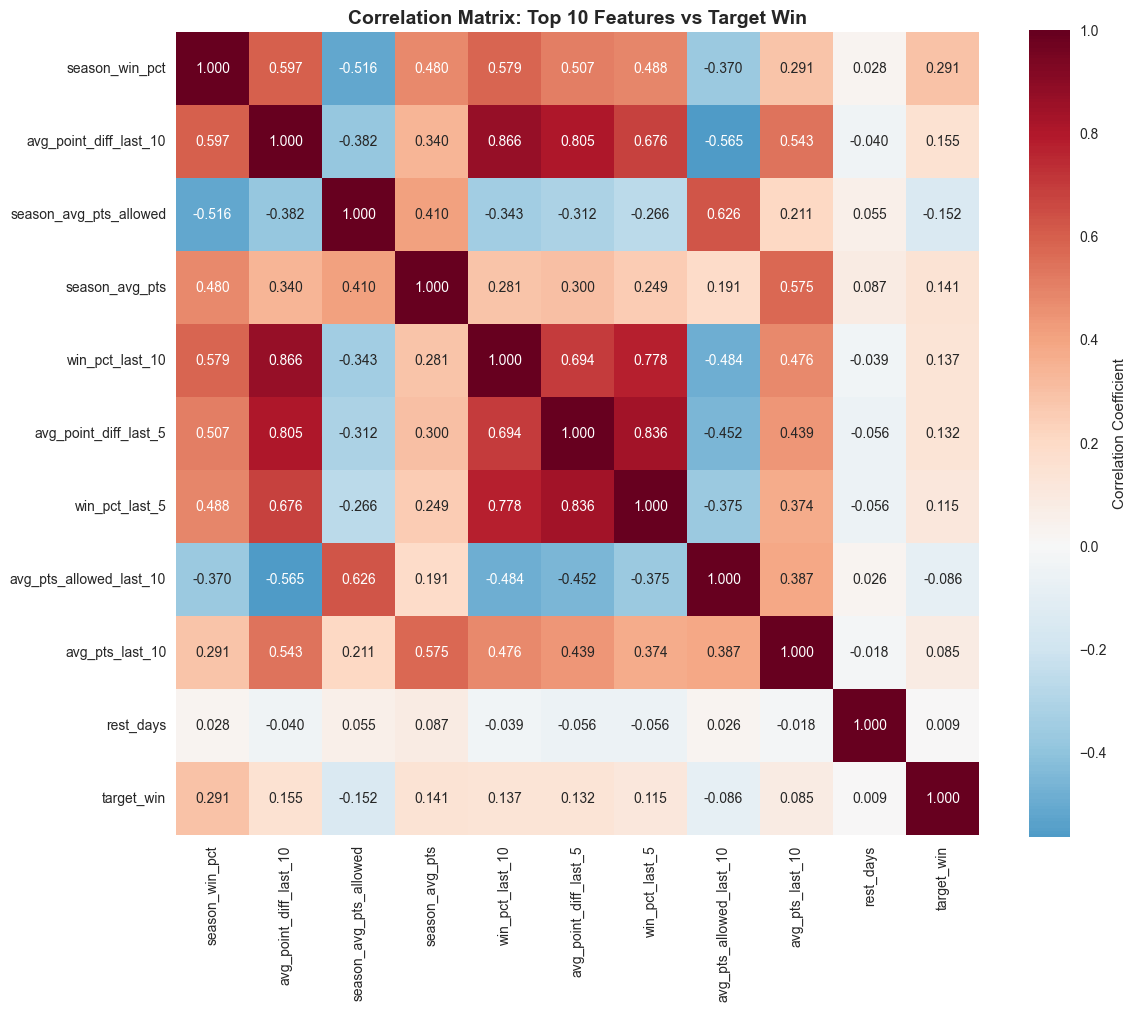


KEY INSIGHTS:
--------------------------------------------------
• Strongest positive predictor: season_win_pct (+0.2912)
• Strongest negative predictor: season_avg_pts_allowed (-0.1516)
• Features with correlation > 0.1: 6
• Features with correlation < -0.1: 1


In [13]:
# Feature Correlation Analysis
if features_df is not None:
    print("FEATURE CORRELATION ANALYSIS")
    print("="*50)
    
    # Select numeric features for correlation analysis
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove non-feature columns
    exclude_cols = ['game_id', 'target_win']
    numeric_features = [col for col in numeric_cols if col not in exclude_cols]
    
    print(f"Analyzing correlations for {len(numeric_features)} numeric features")
    
    # Calculate correlation matrix
    corr_matrix = features_df[numeric_features + ['target_win']].corr()
    
    # Get correlations with target variable
    target_correlations = corr_matrix['target_win'].drop('target_win').sort_values(key=abs, ascending=False)
    
    print("\nTOP 15 FEATURES CORRELATED WITH WINS:")
    print("-" * 50)
    for i, (feature, corr) in enumerate(target_correlations.head(15).items(), 1):
        print(f"{i:2d}. {feature:<30} {corr:+.4f}")
    
    print(f"\nBOTTOM 10 FEATURES CORRELATED WITH WINS:")
    print("-" * 50)
    for i, (feature, corr) in enumerate(target_correlations.tail(10).items(), 1):
        print(f"{i:2d}. {feature:<30} {corr:+.4f}")
    
    # Create correlation heatmap for top features
    top_features = target_correlations.head(10).index.tolist() + ['target_win']
    top_corr_matrix = features_df[top_features].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix: Top 10 Features vs Target Win', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Feature importance insights
    print(f"\nKEY INSIGHTS:")
    print("-" * 50)
    strongest_positive = target_correlations.idxmax()
    strongest_negative = target_correlations.idxmin()
    print(f"• Strongest positive predictor: {strongest_positive} ({target_correlations[strongest_positive]:+.4f})")
    print(f"• Strongest negative predictor: {strongest_negative} ({target_correlations[strongest_negative]:+.4f})")
    print(f"• Features with correlation > 0.1: {len(target_correlations[target_correlations > 0.1])}")
    print(f"• Features with correlation < -0.1: {len(target_correlations[target_correlations < -0.1])}")
    
else:
    print("❌ No features data available for correlation analysis")

TEAM PERFORMANCE VISUALIZATIONS


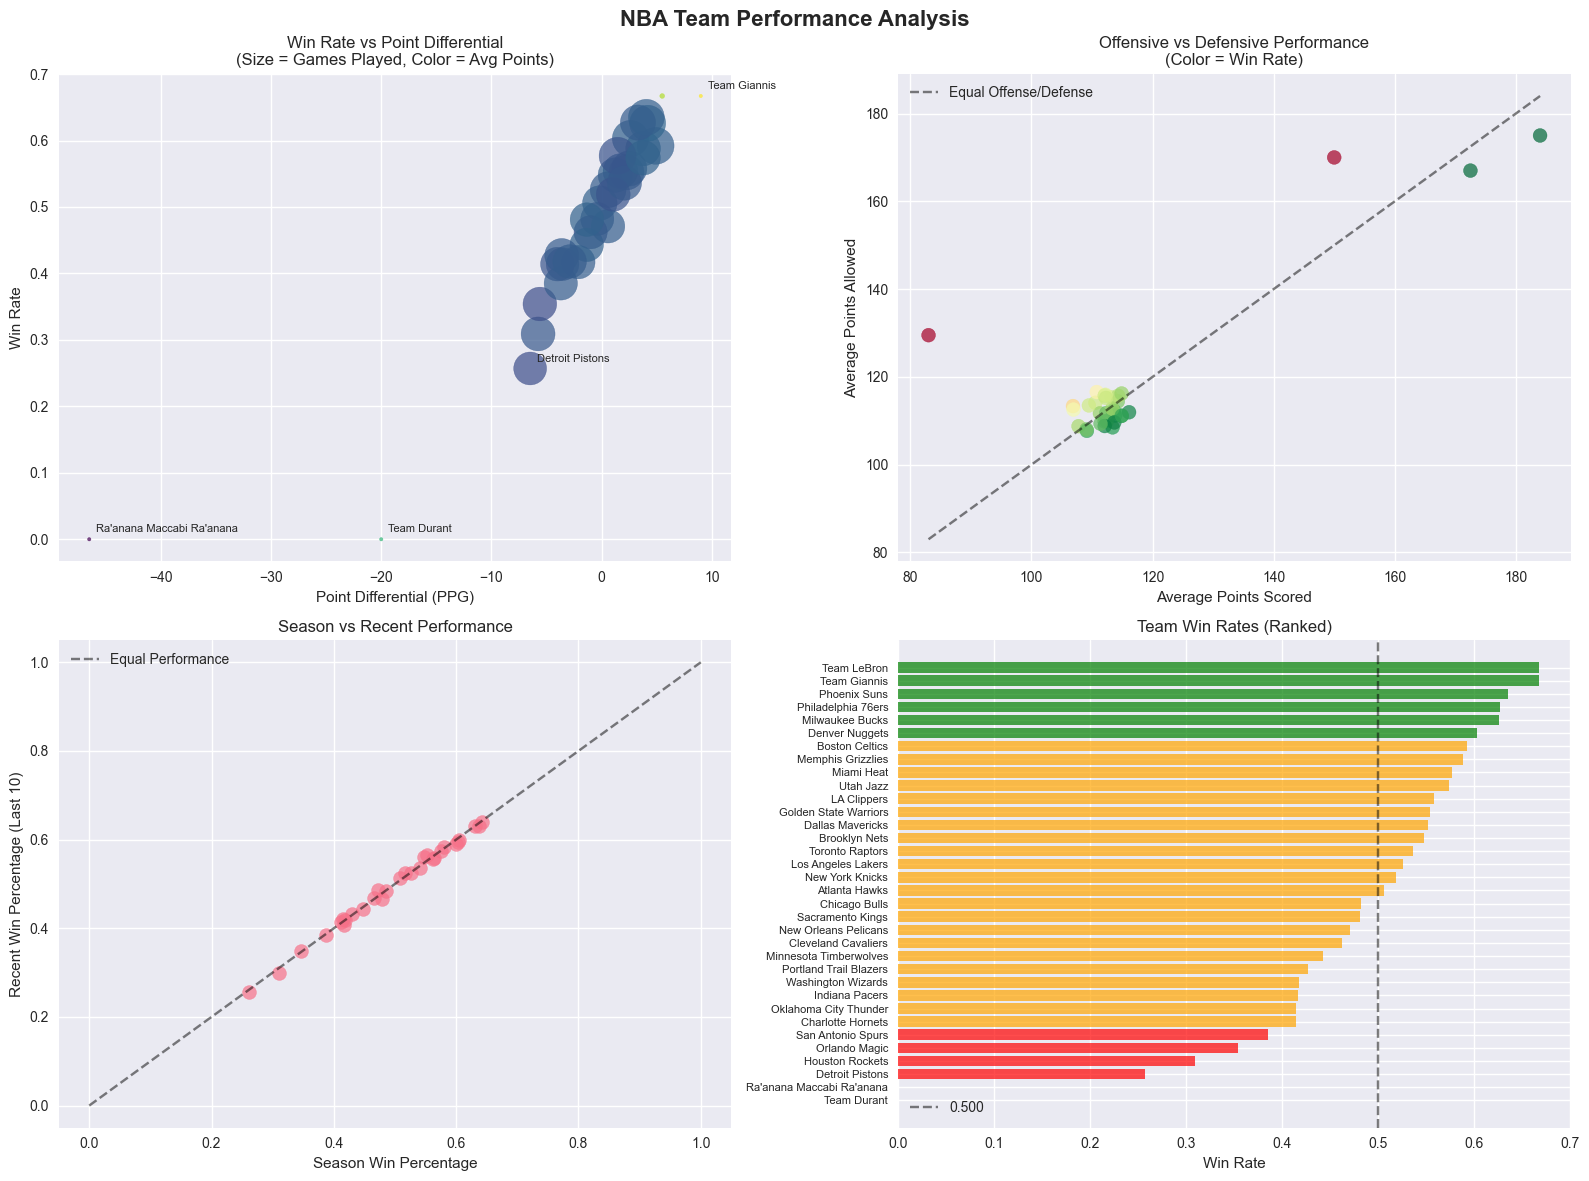


KEY PERFORMANCE INSIGHTS:
--------------------------------------------------
• Best Team: Team Giannis (66.7% win rate)
• Worst Team: Ra'anana Maccabi Ra'anana (0.0% win rate)
• Teams improving recently: 0
• Teams declining recently: 0
• Average point differential: -1.6


In [14]:
# Team Performance Visualization
if features_df is not None:
    print("TEAM PERFORMANCE VISUALIZATIONS")
    print("="*50)
    
    # Calculate team-level aggregations for visualization
    team_performance = features_df.groupby('team_name').agg({
        'target_win': ['count', 'mean'],
        'season_win_pct': 'mean',
        'season_avg_pts': 'mean',
        'season_avg_pts_allowed': 'mean',
        'win_pct_last_10': 'mean',
        'is_home': 'mean'
    }).round(3)
    
    # Flatten column names
    team_performance.columns = ['games_played', 'win_rate', 'season_win_pct', 
                               'avg_pts_scored', 'avg_pts_allowed', 'recent_win_pct', 'home_pct']
    team_performance = team_performance.reset_index()
    
    # Add point differential
    team_performance['point_differential'] = team_performance['avg_pts_scored'] - team_performance['avg_pts_allowed']
    
    # Create subplots for multiple visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NBA Team Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Win Rate vs Point Differential
    scatter = axes[0,0].scatter(team_performance['point_differential'], 
                               team_performance['win_rate'],
                               s=team_performance['games_played']*2,
                               alpha=0.7, c=team_performance['avg_pts_scored'], 
                               cmap='viridis')
    axes[0,0].set_xlabel('Point Differential (PPG)')
    axes[0,0].set_ylabel('Win Rate')
    axes[0,0].set_title('Win Rate vs Point Differential\n(Size = Games Played, Color = Avg Points)')
    
    # Add team labels for extreme values
    for idx, row in team_performance.iterrows():
        if row['point_differential'] > 8 or row['point_differential'] < -8 or row['win_rate'] > 0.7 or row['win_rate'] < 0.3:
            axes[0,0].annotate(row['team_name'], (row['point_differential'], row['win_rate']), 
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 2. Offensive vs Defensive Performance
    axes[0,1].scatter(team_performance['avg_pts_scored'], 
                     team_performance['avg_pts_allowed'],
                     s=100, alpha=0.7, c=team_performance['win_rate'], cmap='RdYlGn')
    axes[0,1].set_xlabel('Average Points Scored')
    axes[0,1].set_ylabel('Average Points Allowed')
    axes[0,1].set_title('Offensive vs Defensive Performance\n(Color = Win Rate)')
    
    # Add diagonal line for reference
    min_pts = min(team_performance['avg_pts_scored'].min(), team_performance['avg_pts_allowed'].min())
    max_pts = max(team_performance['avg_pts_scored'].max(), team_performance['avg_pts_allowed'].max())
    axes[0,1].plot([min_pts, max_pts], [min_pts, max_pts], 'k--', alpha=0.5, label='Equal Offense/Defense')
    axes[0,1].legend()
    
    # 3. Season vs Recent Performance
    axes[1,0].scatter(team_performance['season_win_pct'], 
                     team_performance['recent_win_pct'],
                     s=100, alpha=0.7)
    axes[1,0].set_xlabel('Season Win Percentage')
    axes[1,0].set_ylabel('Recent Win Percentage (Last 10)')
    axes[1,0].set_title('Season vs Recent Performance')
    
    # Add diagonal line
    axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equal Performance')
    axes[1,0].legend()
    
    # Identify teams performing above/below season average recently
    improving = team_performance[team_performance['recent_win_pct'] > team_performance['season_win_pct'] + 0.1]
    declining = team_performance[team_performance['recent_win_pct'] < team_performance['season_win_pct'] - 0.1]
    
    for idx, row in improving.iterrows():
        axes[1,0].annotate(f"{row['team_name']} ↑", 
                          (row['season_win_pct'], row['recent_win_pct']), 
                          xytext=(5, 5), textcoords='offset points', 
                          fontsize=8, color='green')
    
    for idx, row in declining.iterrows():
        axes[1,0].annotate(f"{row['team_name']} ↓", 
                          (row['season_win_pct'], row['recent_win_pct']), 
                          xytext=(5, -15), textcoords='offset points', 
                          fontsize=8, color='red')
    
    # 4. Home Game Advantage Distribution
    team_performance_sorted = team_performance.sort_values('win_rate', ascending=True)
    colors = ['red' if x < 0.4 else 'orange' if x < 0.6 else 'green' for x in team_performance_sorted['win_rate']]
    
    bars = axes[1,1].barh(range(len(team_performance_sorted)), 
                         team_performance_sorted['win_rate'],
                         color=colors, alpha=0.7)
    axes[1,1].set_yticks(range(len(team_performance_sorted)))
    axes[1,1].set_yticklabels(team_performance_sorted['team_name'], fontsize=8)
    axes[1,1].set_xlabel('Win Rate')
    axes[1,1].set_title('Team Win Rates (Ranked)')
    axes[1,1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='0.500')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    print(f"\nKEY PERFORMANCE INSIGHTS:")
    print("-" * 50)
    best_team = team_performance.loc[team_performance['win_rate'].idxmax()]
    worst_team = team_performance.loc[team_performance['win_rate'].idxmin()]
    
    print(f"• Best Team: {best_team['team_name']} ({best_team['win_rate']:.1%} win rate)")
    print(f"• Worst Team: {worst_team['team_name']} ({worst_team['win_rate']:.1%} win rate)")
    print(f"• Teams improving recently: {len(improving)}")
    print(f"• Teams declining recently: {len(declining)}")
    print(f"• Average point differential: {team_performance['point_differential'].mean():+.1f}")
    
else:
    print("❌ No features data available for team performance visualization")

In [15]:
# Interactive Team Performance Dashboard with Plotly
if features_df is not None:
    print("INTERACTIVE TEAM PERFORMANCE DASHBOARD")
    print("="*50)
    
    # Prepare data for interactive visualizations
    team_perf = features_df.groupby('team_name').agg({
        'target_win': ['count', 'mean'],
        'season_win_pct': 'mean',
        'season_avg_pts': 'mean',
        'season_avg_pts_allowed': 'mean',
        'win_pct_last_10': 'mean',
        'is_home': 'mean'
    }).round(3)
    
    team_perf.columns = ['games_played', 'win_rate', 'season_win_pct', 
                        'avg_pts_scored', 'avg_pts_allowed', 'recent_win_pct', 'home_pct']
    team_perf = team_perf.reset_index()
    team_perf['point_differential'] = team_perf['avg_pts_scored'] - team_perf['avg_pts_allowed']
    
    # Create interactive scatter plot
    fig = px.scatter(team_perf, 
                     x='point_differential', 
                     y='win_rate',
                     size='games_played',
                     color='avg_pts_scored',
                     hover_name='team_name',
                     hover_data=['season_win_pct', 'recent_win_pct', 'avg_pts_allowed'],
                     title='Team Performance: Win Rate vs Point Differential',
                     labels={'point_differential': 'Point Differential (PPG)',
                            'win_rate': 'Win Rate',
                            'avg_pts_scored': 'Avg Points Scored'},
                     color_continuous_scale='viridis')
    
    fig.update_layout(height=600, showlegend=True)
    fig.show()
    
    # Create a team comparison dashboard
    fig2 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Offensive vs Defensive Rating', 'Season vs Recent Form', 
                       'Win Rate Distribution', 'Point Differential Ranking'),
        specs=[[{"type": "scatter"}, {"type": "scatter"}],
               [{"type": "bar"}, {"type": "bar"}]]
    )
    
    # Subplot 1: Offense vs Defense
    fig2.add_trace(
        go.Scatter(x=team_perf['avg_pts_scored'], 
                  y=team_perf['avg_pts_allowed'],
                  mode='markers+text',
                  text=team_perf['team_name'],
                  textposition='top center',
                  marker=dict(size=10, color=team_perf['win_rate'], 
                             colorscale='RdYlGn', showscale=True),
                  name='Teams'),
        row=1, col=1
    )
    
    # Subplot 2: Season vs Recent
    fig2.add_trace(
        go.Scatter(x=team_perf['season_win_pct'], 
                  y=team_perf['recent_win_pct'],
                  mode='markers+text',
                  text=team_perf['team_name'],
                  textposition='top center',
                  marker=dict(size=8),
                  name='Performance'),
        row=1, col=2
    )
    
    # Subplot 3: Win Rate Distribution
    team_perf_sorted = team_perf.sort_values('win_rate')
    colors = ['red' if x < 0.4 else 'orange' if x < 0.6 else 'green' 
              for x in team_perf_sorted['win_rate']]
    
    fig2.add_trace(
        go.Bar(x=team_perf_sorted['win_rate'],
               y=team_perf_sorted['team_name'],
               orientation='h',
               marker_color=colors,
               name='Win Rate'),
        row=2, col=1
    )
    
    # Subplot 4: Point Differential
    team_diff_sorted = team_perf.sort_values('point_differential')
    colors2 = ['red' if x < -5 else 'orange' if x < 0 else 'lightgreen' if x < 5 else 'green' 
               for x in team_diff_sorted['point_differential']]
    
    fig2.add_trace(
        go.Bar(x=team_diff_sorted['point_differential'],
               y=team_diff_sorted['team_name'],
               orientation='h',
               marker_color=colors2,
               name='Point Diff'),
        row=2, col=2
    )
    
    fig2.update_layout(height=800, showlegend=False, title_text="NBA Team Performance Dashboard")
    fig2.update_xaxes(title_text="Points Scored", row=1, col=1)
    fig2.update_yaxes(title_text="Points Allowed", row=1, col=1)
    fig2.update_xaxes(title_text="Season Win %", row=1, col=2)
    fig2.update_yaxes(title_text="Recent Win %", row=1, col=2)
    fig2.update_xaxes(title_text="Win Rate", row=2, col=1)
    fig2.update_xaxes(title_text="Point Differential", row=2, col=2)
    
    fig2.show()
    
    # Performance insights
    print(f"\nKEY INSIGHTS FROM TEAM ANALYSIS:")
    print("-" * 50)
    
    best_team = team_perf.loc[team_perf['win_rate'].idxmax()]
    worst_team = team_perf.loc[team_perf['win_rate'].idxmin()]
    highest_scoring = team_perf.loc[team_perf['avg_pts_scored'].idxmax()]
    best_defense = team_perf.loc[team_perf['avg_pts_allowed'].idxmin()]
    
    print(f"• Best Overall Team: {best_team['team_name']} ({best_team['win_rate']:.1%} win rate)")
    print(f"• Struggling Team: {worst_team['team_name']} ({worst_team['win_rate']:.1%} win rate)")
    print(f"• Highest Scoring: {highest_scoring['team_name']} ({highest_scoring['avg_pts_scored']:.1f} PPG)")
    print(f"• Best Defense: {best_defense['team_name']} ({best_defense['avg_pts_allowed']:.1f} PPG allowed)")
    
    # Form analysis
    improving_teams = team_perf[team_perf['recent_win_pct'] > team_perf['season_win_pct'] + 0.1]
    declining_teams = team_perf[team_perf['recent_win_pct'] < team_perf['season_win_pct'] - 0.1]
    
    print(f"• Teams trending up: {len(improving_teams)} teams")
    if len(improving_teams) > 0:
        print(f"  - {', '.join(improving_teams['team_name'].tolist())}")
    
    print(f"• Teams trending down: {len(declining_teams)} teams")
    if len(declining_teams) > 0:
        print(f"  - {', '.join(declining_teams['team_name'].tolist())}")
    
    print(f"• League average point differential: {team_perf['point_differential'].mean():+.1f}")
    print(f"• Most balanced team (closest to 0 diff): {team_perf.loc[team_perf['point_differential'].abs().idxmin(), 'team_name']}")
    
else:
    print("❌ No features data available for interactive team performance analysis")

INTERACTIVE TEAM PERFORMANCE DASHBOARD



KEY INSIGHTS FROM TEAM ANALYSIS:
--------------------------------------------------
• Best Overall Team: Team Giannis (66.7% win rate)
• Struggling Team: Ra'anana Maccabi Ra'anana (0.0% win rate)
• Highest Scoring: Team Giannis (184.0 PPG)
• Best Defense: Miami Heat (107.7 PPG allowed)
• Teams trending up: 0 teams
• Teams trending down: 0 teams
• League average point differential: -1.6
• Most balanced team (closest to 0 diff): Atlanta Hawks


In [ ]:
## 2. Team Performance Analysis

## Let's analyze team performance across different metrics and create visualizations to understand team strengths and weaknesses.


In [16]:
# Team Performance Analysis
if features_df is not None:
    # Calculate team statistics
    team_stats = features_df.groupby('team_name').agg({
        'target_win': ['count', 'mean'],
        'season_win_pct': 'mean',
        'season_avg_pts': 'mean',
        'season_avg_pts_allowed': 'mean',
        'avg_pts_last_10': 'mean',
        'avg_pts_allowed_last_10': 'mean',
        'win_pct_last_10': 'mean',
        'is_home': 'mean'  # Home game percentage
    }).round(3)
    
    # Flatten column names
    team_stats.columns = ['_'.join(col).strip() for col in team_stats.columns]
    team_stats = team_stats.reset_index()
    
    # Rename columns for clarity
    team_stats.columns = [
        'team_name', 'games_played', 'win_rate', 'season_win_pct', 'season_avg_pts', 
        'season_avg_pts_allowed', 'recent_avg_pts', 'recent_avg_pts_allowed', 
        'recent_win_pct', 'home_game_pct'
    ]
    
    # Calculate point differential
    team_stats['season_point_diff'] = team_stats['season_avg_pts'] - team_stats['season_avg_pts_allowed']
    team_stats['recent_point_diff'] = team_stats['recent_avg_pts'] - team_stats['recent_avg_pts_allowed']
    
    print("TEAM STATISTICS CALCULATED")
    print("="*50)
    print(f"Analyzed {len(team_stats)} teams")
    print(f"Calculated {len(team_stats.columns)-1} performance metrics per team")
    
    # Show basic stats
    print(f"\nLeague Averages:")
    print(f"• Average Win Rate: {team_stats['win_rate'].mean():.1%}")
    print(f"• Average Points Per Game: {team_stats['season_avg_pts'].mean():.1f}")
    print(f"• Average Points Allowed: {team_stats['season_avg_pts_allowed'].mean():.1f}")
    print(f"• Average Point Differential: {team_stats['season_point_diff'].mean():+.1f}")
    
else:
    print("No features data available for team analysis")


TEAM STATISTICS CALCULATED
Analyzed 34 teams
Calculated 11 performance metrics per team

League Averages:
• Average Win Rate: 47.6%
• Average Points Per Game: 116.2
• Average Points Allowed: 117.8
• Average Point Differential: -1.6


In [17]:
# Display top teams rankings and performance tables
if features_df is not None and 'team_stats' in locals():
    
    print("TOP TEAMS BY WIN RATE")
    print("="*50)
    top_win_rate = team_stats.nlargest(10, 'win_rate')[['team_name', 'games_played', 'win_rate', 'season_win_pct', 'season_point_diff']]
    display(top_win_rate)
    
    print("\nHIGHEST SCORING TEAMS")
    print("="*50)
    top_scoring = team_stats.nlargest(10, 'season_avg_pts')[['team_name', 'season_avg_pts', 'season_avg_pts_allowed', 'season_point_diff']]
    display(top_scoring)
    
    print("\nBEST DEFENSIVE TEAMS (Lowest Points Allowed)")
    print("="*50)
    best_defense = team_stats.nsmallest(10, 'season_avg_pts_allowed')[['team_name', 'season_avg_pts_allowed', 'season_avg_pts', 'season_point_diff']]
    display(best_defense)
    
    print("\nLARGEST POINT DIFFERENTIALS")
    print("="*50)
    best_diff = team_stats.nlargest(10, 'season_point_diff')[['team_name', 'season_point_diff', 'season_avg_pts', 'season_avg_pts_allowed', 'win_rate']]
    display(best_diff)
    
    # Summary statistics
    print("\nLEAGUE SUMMARY STATISTICS")
    print("="*50)
    print(f"Teams analyzed: {len(team_stats)}")
    print(f"Win rate range: {team_stats['win_rate'].min():.1%} - {team_stats['win_rate'].max():.1%}")
    print(f"Scoring range: {team_stats['season_avg_pts'].min():.1f} - {team_stats['season_avg_pts'].max():.1f} PPG")
    print(f"Point diff range: {team_stats['season_point_diff'].min():+.1f} to {team_stats['season_point_diff'].max():+.1f}")
    
else:
    print("Team statistics not available for display")


TOP TEAMS BY WIN RATE


,team_name,games_played,win_rate,season_win_pct,season_point_diff
29,Team Giannis,3,0.667,1.000,9.000
30,Team LeBron,6,0.667,0.500,5.500
23,Phoenix Suns,334,0.635,0.642,4.061
22,Philadelphia 76ers,322,0.627,0.631,3.300
16,Milwaukee Bucks,337,0.626,0.638,4.177
7,Denver Nuggets,343,0.603,0.605,2.623
1,Boston Celtics,353,0.592,0.603,4.901
14,Memphis Grizzlies,313,0.588,0.600,3.766
15,Miami Heat,355,0.577,0.580,1.453
32,Utah Jazz,310,0.574,0.576,3.762



HIGHEST SCORING TEAMS


,team_name,season_avg_pts,season_avg_pts_allowed,season_point_diff
29,Team Giannis,184.000,175.000,9.000
30,Team LeBron,172.500,167.000,5.500
28,Team Durant,150.000,170.000,-20.000
16,Milwaukee Bucks,116.120,111.943,4.177
32,Utah Jazz,114.917,111.155,3.762
26,Sacramento Kings,114.891,116.219,-1.328
14,Memphis Grizzlies,114.881,111.115,3.766
17,Minnesota Timberwolves,114.334,115.688,-1.354
0,Atlanta Hawks,114.266,114.428,-0.162
7,Denver Nuggets,113.823,111.200,2.623



BEST DEFENSIVE TEAMS (Lowest Points Allowed)


,team_name,season_avg_pts_allowed,season_avg_pts,season_point_diff
15,Miami Heat,107.703,109.156,1.453
19,New York Knicks,108.036,109.091,1.055
1,Boston Celtics,108.495,113.396,4.901
5,Cleveland Cavaliers,108.767,107.770,-0.997
22,Philadelphia 76ers,108.798,112.098,3.300
31,Toronto Raptors,109.332,111.403,2.071
23,Phoenix Suns,109.622,113.683,4.061
6,Dallas Mavericks,109.831,112.088,2.257
12,LA Clippers,109.930,112.444,2.514
14,Memphis Grizzlies,111.115,114.881,3.766



LARGEST POINT DIFFERENTIALS


,team_name,season_point_diff,season_avg_pts,season_avg_pts_allowed,win_rate
29,Team Giannis,9.000,184.000,175.000,0.667
30,Team LeBron,5.500,172.500,167.000,0.667
1,Boston Celtics,4.901,113.396,108.495,0.592
16,Milwaukee Bucks,4.177,116.120,111.943,0.626
23,Phoenix Suns,4.061,113.683,109.622,0.635
14,Memphis Grizzlies,3.766,114.881,111.115,0.588
32,Utah Jazz,3.762,114.917,111.155,0.574
22,Philadelphia 76ers,3.300,112.098,108.798,0.627
7,Denver Nuggets,2.623,113.823,111.200,0.603
12,LA Clippers,2.514,112.444,109.930,0.558



LEAGUE SUMMARY STATISTICS
Teams analyzed: 34
Win rate range: 0.0% - 66.7%
Scoring range: 83.0 - 184.0 PPG
Point diff range: -46.5 to +9.0


# 3. Model Performance & Betting Analysis

Now let's analyze the model's performance and examine betting patterns, predictions accuracy, and potential profitability insights.

In [ ]:
# Model Performance Analysis
if performance_available:
    print("MODEL PERFORMANCE ANALYSIS")
    print("="*50)
    
    # Connect to performance database
    conn = sqlite3.connect(performance_db)
    
    try:
        # Load prediction performance data
        # First check what tables exist
        tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
        tables_df = pd.read_sql_query(tables_query, conn)
        print(f"Available tables: {tables_df['name'].tolist()}")
        
        # Check predictions table schema
        schema_query = "PRAGMA table_info(predictions);"
        schema_df = pd.read_sql_query(schema_query, conn)
        print(f"Predictions table columns: {schema_df['name'].tolist()}")
        
        predictions_query = """
        SELECT * FROM predictions 
        LIMIT 1000
        """
        predictions_df = pd.read_sql_query(predictions_query, conn)
        
        if not predictions_df.empty:
            print(f"✅ Loaded {len(predictions_df)} recent predictions")
            predictions_df['prediction_date'] = pd.to_datetime(predictions_df['prediction_date'])
            
            # Calculate performance metrics
            if 'actual_outcome' in predictions_df.columns and 'predicted_outcome' in predictions_df.columns:
                accuracy = (predictions_df['actual_outcome'] == predictions_df['predicted_outcome']).mean()
                print(f"• Overall Model Accuracy: {accuracy:.1%}")
                
                # Accuracy by confidence level (if available)
                if 'confidence' in predictions_df.columns:
                    predictions_df['confidence_bucket'] = pd.cut(predictions_df['confidence'], 
                                                               bins=[0, 0.6, 0.7, 0.8, 1.0], 
                                                               labels=['Low (≤60%)', 'Medium (60-70%)', 
                                                                      'High (70-80%)', 'Very High (>80%)'])
                    accuracy_by_conf = predictions_df.groupby('confidence_bucket').agg({
                        'predicted_outcome': 'count',
                        'actual_outcome': lambda x: (predictions_df.loc[x.index, 'actual_outcome'] == 
                                                    predictions_df.loc[x.index, 'predicted_outcome']).sum()
                    })
                    accuracy_by_conf['accuracy'] = accuracy_by_conf['actual_outcome'] / accuracy_by_conf['predicted_outcome']
                    
                    print(f"\nAccuracy by Confidence Level:")
                    for conf_level in accuracy_by_conf.index:
                        if pd.notna(conf_level):
                            acc = accuracy_by_conf.loc[conf_level, 'accuracy']
                            count = accuracy_by_conf.loc[conf_level, 'predicted_outcome']
                            print(f"• {conf_level}: {acc:.1%} ({count} predictions)")
        
        # Load betting performance data if available
        betting_query = """
        SELECT * FROM betting_performance 
        ORDER BY bet_date DESC
        LIMIT 500
        """
        try:
            betting_df = pd.read_sql_query(betting_query, conn)
            if not betting_df.empty:
                print(f"\n✅ Loaded {len(betting_df)} betting records")
                betting_df['bet_date'] = pd.to_datetime(betting_df['bet_date'])
                
                # Calculate betting metrics
                if 'profit_loss' in betting_df.columns:
                    total_profit = betting_df['profit_loss'].sum()
                    total_bets = len(betting_df)
                    win_rate = (betting_df['profit_loss'] > 0).mean() if 'profit_loss' in betting_df.columns else None
                    avg_bet = betting_df['bet_amount'].mean() if 'bet_amount' in betting_df.columns else None
                    
                    print(f"• Total Profit/Loss: ${total_profit:,.2f}")
                    print(f"• Total Bets Placed: {total_bets}")
                    if win_rate is not None:
                        print(f"• Betting Win Rate: {win_rate:.1%}")
                    if avg_bet is not None:
                        print(f"• Average Bet Size: ${avg_bet:.2f}")
                        
                    # ROI calculation
                    total_wagered = betting_df['bet_amount'].sum() if 'bet_amount' in betting_df.columns else None
                    if total_wagered and total_wagered > 0:
                        roi = (total_profit / total_wagered) * 100
                        print(f"• Return on Investment (ROI): {roi:+.2f}%")
                        
        except Exception as e:
            print(f"• No betting performance data available: {str(e)}")
            betting_df = None
            
    except Exception as e:
        print(f"❌ Error loading performance data: {str(e)}")
        predictions_df = None
        betting_df = None
    finally:
        conn.close()
        
else:
    print("❌ No performance database available for analysis")
    predictions_df = None
    betting_df = None

# Analyze recent games for prediction opportunities
if games_df is not None:
    print(f"\nRECENT GAMES ANALYSIS (2024-2025 Season)")
    print("="*50)
    
    # First check what columns we have
    print(f"Available columns: {list(games_df.columns[:10])}...")  # Show first 10 columns
    
    # Game frequency analysis
    games_by_date = games_df.groupby(games_df['game_date'].dt.date).size()
    print(f"• Total games in dataset: {len(games_df)}")
    print(f"• Date range: {games_df['game_date'].min().date()} to {games_df['game_date'].max().date()}")
    print(f"• Average games per day: {games_by_date.mean():.1f}")
    print(f"• Most games in one day: {games_by_date.max()}")

MODEL PERFORMANCE ANALYSIS
Available tables: ['predictions', 'sqlite_sequence', 'daily_performance', 'model_performance']
• No betting performance data available: Execution failed on sql '
        SELECT * FROM betting_performance 
        ORDER BY bet_date DESC
        LIMIT 500
        ': no such table: betting_performance

RECENT GAMES ANALYSIS (2024-2025 Season)
Available columns: ['season_id', 'team_id_home', 'team_abbreviation_home', 'team_name_home', 'game_id', 'game_date', 'matchup_home', 'wl_home', 'min', 'fgm_home']...
• Total games in dataset: 65698
• Date range: 1946-11-01 to 2023-06-12
• Average games per day: 5.1
• Most games in one day: 15


In [19]:
# Model Performance Visualization and Betting Trends
if 'predictions_df' in locals() and predictions_df is not None and not predictions_df.empty:
    print("MODEL PERFORMANCE VISUALIZATIONS")
    print("="*50)
    
    # Create comprehensive performance dashboard
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Prediction Accuracy Over Time', 'Confidence Distribution', 
                       'Accuracy by Confidence Level', 'Prediction Volume by Date'),
        specs=[[{"secondary_y": False}, {"type": "histogram"}],
               [{"type": "bar"}, {"secondary_y": False}]]
    )
    
    # 1. Accuracy over time (if we have enough data)
    if len(predictions_df) > 10:
        predictions_df['prediction_week'] = predictions_df['prediction_date'].dt.to_period('W')
        weekly_accuracy = predictions_df.groupby('prediction_week').agg({
            'predicted_outcome': 'count',
            'actual_outcome': lambda x: (predictions_df.loc[x.index, 'actual_outcome'] == 
                                       predictions_df.loc[x.index, 'predicted_outcome']).sum()
        })
        weekly_accuracy['accuracy'] = weekly_accuracy['actual_outcome'] / weekly_accuracy['predicted_outcome']
        
        fig.add_trace(
            go.Scatter(x=[str(w) for w in weekly_accuracy.index], 
                      y=weekly_accuracy['accuracy'],
                      mode='lines+markers',
                      name='Weekly Accuracy',
                      line=dict(color='blue')),
            row=1, col=1
        )
        
        # Add horizontal line at 50% (random baseline)
        fig.add_hline(y=0.5, line_dash="dash", line_color="red", 
                     annotation_text="Random Baseline (50%)", row=1, col=1)
    
    # 2. Confidence distribution
    if 'confidence' in predictions_df.columns:
        fig.add_trace(
            go.Histogram(x=predictions_df['confidence'], 
                        nbinsx=20, 
                        name='Confidence Distribution',
                        marker_color='lightblue'),
            row=1, col=2
        )
    
    # 3. Accuracy by confidence level
    if 'confidence_bucket' in predictions_df.columns:
        conf_accuracy = predictions_df.groupby('confidence_bucket').agg({
            'predicted_outcome': 'count',
            'actual_outcome': lambda x: (predictions_df.loc[x.index, 'actual_outcome'] == 
                                       predictions_df.loc[x.index, 'predicted_outcome']).sum()
        })
        conf_accuracy['accuracy'] = conf_accuracy['actual_outcome'] / conf_accuracy['predicted_outcome']
        
        colors = ['red', 'orange', 'lightgreen', 'green']
        fig.add_trace(
            go.Bar(x=[str(idx) for idx in conf_accuracy.index if pd.notna(idx)], 
                   y=[conf_accuracy.loc[idx, 'accuracy'] for idx in conf_accuracy.index if pd.notna(idx)],
                   name='Accuracy by Confidence',
                   marker_color=colors[:len([idx for idx in conf_accuracy.index if pd.notna(idx)])]),
            row=2, col=1
        )
        
        # Add baseline
        fig.add_hline(y=0.5, line_dash="dash", line_color="red", row=2, col=1)
    
    # 4. Prediction volume over time
    daily_predictions = predictions_df.groupby(predictions_df['prediction_date'].dt.date).size()
    fig.add_trace(
        go.Scatter(x=list(daily_predictions.index), 
                  y=daily_predictions.values,
                  mode='lines+markers',
                  name='Daily Predictions',
                  line=dict(color='purple')),
        row=2, col=2
    )
    
    fig.update_layout(height=800, title_text="Model Performance Dashboard", showlegend=False)
    fig.update_xaxes(title_text="Week", row=1, col=1)
    fig.update_yaxes(title_text="Accuracy", row=1, col=1)
    fig.update_xaxes(title_text="Confidence Score", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    fig.update_xaxes(title_text="Confidence Level", row=2, col=1)
    fig.update_yaxes(title_text="Accuracy", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=2)
    fig.update_yaxes(title_text="Number of Predictions", row=2, col=2)
    
    fig.show()
    
    # Performance summary statistics
    print(f"\nMODEL PERFORMANCE SUMMARY:")
    print("-" * 50)
    if 'actual_outcome' in predictions_df.columns and 'predicted_outcome' in predictions_df.columns:
        overall_accuracy = (predictions_df['actual_outcome'] == predictions_df['predicted_outcome']).mean()
        print(f"• Overall Accuracy: {overall_accuracy:.1%}")
        
        # Calculate precision, recall if we have binary outcomes
        if predictions_df['actual_outcome'].nunique() == 2:
            true_positives = ((predictions_df['actual_outcome'] == 1) & (predictions_df['predicted_outcome'] == 1)).sum()
            false_positives = ((predictions_df['actual_outcome'] == 0) & (predictions_df['predicted_outcome'] == 1)).sum()
            false_negatives = ((predictions_df['actual_outcome'] == 1) & (predictions_df['predicted_outcome'] == 0)).sum()
            
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            print(f"• Precision: {precision:.1%}")
            print(f"• Recall: {recall:.1%}")
            print(f"• F1 Score: {f1_score:.3f}")
    
    if 'confidence' in predictions_df.columns:
        print(f"• Average Confidence: {predictions_df['confidence'].mean():.1%}")
        print(f"• Confidence Range: {predictions_df['confidence'].min():.1%} - {predictions_df['confidence'].max():.1%}")

# Betting Performance Visualization
if 'betting_df' in locals() and betting_df is not None and not betting_df.empty:
    print(f"\nBETTING PERFORMANCE VISUALIZATIONS")
    print("="*50)
    
    # Create betting performance dashboard
    fig2 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Cumulative Profit/Loss', 'Bet Size Distribution', 
                       'Win Rate by Bet Size', 'Daily P&L'),
        specs=[[{"secondary_y": False}, {"type": "histogram"}],
               [{"type": "scatter"}, {"secondary_y": False}]]
    )
    
    # 1. Cumulative P&L
    if 'profit_loss' in betting_df.columns:
        betting_df_sorted = betting_df.sort_values('bet_date')
        betting_df_sorted['cumulative_pnl'] = betting_df_sorted['profit_loss'].cumsum()
        
        fig2.add_trace(
            go.Scatter(x=betting_df_sorted['bet_date'], 
                      y=betting_df_sorted['cumulative_pnl'],
                      mode='lines',
                      name='Cumulative P&L',
                      line=dict(color='green' if betting_df_sorted['cumulative_pnl'].iloc[-1] > 0 else 'red')),
            row=1, col=1
        )
        
        # Add break-even line
        fig2.add_hline(y=0, line_dash="dash", line_color="black", 
                      annotation_text="Break Even", row=1, col=1)
    
    # 2. Bet size distribution
    if 'bet_amount' in betting_df.columns:
        fig2.add_trace(
            go.Histogram(x=betting_df['bet_amount'], 
                        nbinsx=20, 
                        name='Bet Size Distribution',
                        marker_color='lightcoral'),
            row=1, col=2
        )
    
    # 3. Win rate by bet size (if we have enough data)
    if 'bet_amount' in betting_df.columns and 'profit_loss' in betting_df.columns:
        betting_df['bet_size_bucket'] = pd.qcut(betting_df['bet_amount'], 
                                               q=min(5, len(betting_df.bet_amount.unique())), 
                                               labels=False, duplicates='drop')
        bet_size_analysis = betting_df.groupby('bet_size_bucket').agg({
            'profit_loss': ['count', lambda x: (x > 0).mean(), 'mean'],
            'bet_amount': 'mean'
        })
        bet_size_analysis.columns = ['bet_count', 'win_rate', 'avg_pnl', 'avg_bet_size']
        
        fig2.add_trace(
            go.Scatter(x=bet_size_analysis['avg_bet_size'], 
                      y=bet_size_analysis['win_rate'],
                      mode='markers',
                      marker=dict(size=bet_size_analysis['bet_count']*2, 
                                 color=bet_size_analysis['avg_pnl'],
                                 colorscale='RdYlGn', 
                                 showscale=True),
                      name='Win Rate vs Bet Size'),
            row=2, col=1
        )
    
    # 4. Daily P&L
    if 'profit_loss' in betting_df.columns:
        daily_pnl = betting_df.groupby(betting_df['bet_date'].dt.date)['profit_loss'].sum()
        colors = ['green' if x > 0 else 'red' for x in daily_pnl.values]
        
        fig2.add_trace(
            go.Bar(x=list(daily_pnl.index), 
                   y=daily_pnl.values,
                   marker_color=colors,
                   name='Daily P&L'),
            row=2, col=2
        )
        
        fig2.add_hline(y=0, line_dash="dash", line_color="black", row=2, col=2)
    
    fig2.update_layout(height=800, title_text="Betting Performance Dashboard", showlegend=False)
    fig2.update_xaxes(title_text="Date", row=1, col=1)
    fig2.update_yaxes(title_text="Cumulative P&L ($)", row=1, col=1)
    fig2.update_xaxes(title_text="Bet Amount ($)", row=1, col=2)
    fig2.update_yaxes(title_text="Frequency", row=1, col=2)
    fig2.update_xaxes(title_text="Average Bet Size ($)", row=2, col=1)
    fig2.update_yaxes(title_text="Win Rate", row=2, col=1)
    fig2.update_xaxes(title_text="Date", row=2, col=2)
    fig2.update_yaxes(title_text="Daily P&L ($)", row=2, col=2)
    
    fig2.show()
    
    # Betting insights
    print(f"\nBETTING PERFORMANCE INSIGHTS:")
    print("-" * 50)
    if 'profit_loss' in betting_df.columns:
        total_profit = betting_df['profit_loss'].sum()
        winning_bets = (betting_df['profit_loss'] > 0).sum()
        losing_bets = (betting_df['profit_loss'] < 0).sum()
        win_rate = winning_bets / len(betting_df)
        
        print(f"• Total Profit/Loss: ${total_profit:,.2f}")
        print(f"• Winning Bets: {winning_bets} ({win_rate:.1%})")
        print(f"• Losing Bets: {losing_bets}")
        
        if winning_bets > 0:
            avg_win = betting_df[betting_df['profit_loss'] > 0]['profit_loss'].mean()
            print(f"• Average Win: ${avg_win:.2f}")
        
        if losing_bets > 0:
            avg_loss = betting_df[betting_df['profit_loss'] < 0]['profit_loss'].mean()
            print(f"• Average Loss: ${avg_loss:.2f}")
        
        # Streaks analysis
        betting_df_sorted = betting_df.sort_values('bet_date')
        betting_df_sorted['is_win'] = betting_df_sorted['profit_loss'] > 0
        
        # Calculate winning and losing streaks
        streaks = []
        current_streak = 1
        current_type = betting_df_sorted['is_win'].iloc[0]
        
        for i in range(1, len(betting_df_sorted)):
            if betting_df_sorted['is_win'].iloc[i] == current_type:
                current_streak += 1
            else:
                streaks.append((current_type, current_streak))
                current_streak = 1
                current_type = betting_df_sorted['is_win'].iloc[i]
        streaks.append((current_type, current_streak))
        
        win_streaks = [s[1] for s in streaks if s[0]]
        lose_streaks = [s[1] for s in streaks if not s[0]]
        
        if win_streaks:
            print(f"• Longest Winning Streak: {max(win_streaks)} bets")
        if lose_streaks:
            print(f"• Longest Losing Streak: {max(lose_streaks)} bets")

elif 'predictions_df' not in locals() or predictions_df is None or predictions_df.empty:
    print("MODEL PERFORMANCE VISUALIZATION")
    print("="*50)
    print("❌ No prediction data available for visualization")
    print("• Run the model on recent games to generate prediction data")
    print("• Ensure performance tracking is enabled in the pipeline")
    
    # Create placeholder visualization for recent games analysis
    if games_df is not None:
        print(f"\nGAME TRENDS ANALYSIS (Available Data)")
        print("-" * 50)
        
        # Analyze scoring trends over time
        if 'home_score' in games_df.columns and 'away_score' in games_df.columns:
            games_df['total_points'] = games_df['home_score'] + games_df['away_score']
            games_df['game_month'] = games_df['game_date'].dt.to_period('M')
            
            monthly_stats = games_df.groupby('game_month').agg({
                'total_points': 'mean',
                'home_score': 'mean',
                'away_score': 'mean'
            }).round(1)
            
            # Create simple scoring trends plot
            fig = px.line(x=[str(m) for m in monthly_stats.index], 
                         y=monthly_stats['total_points'],
                         title='Average Total Points Per Game by Month',
                         labels={'x': 'Month', 'y': 'Average Total Points'})
            fig.show()
            
            print(f"• Highest scoring month: {monthly_stats['total_points'].idxmax()} ({monthly_stats['total_points'].max():.1f} PPG)")
            print(f"• Lowest scoring month: {monthly_stats['total_points'].idxmin()} ({monthly_stats['total_points'].min():.1f} PPG)")

print(f"\nRECOMMENDATIONS FOR IMPROVING ANALYSIS:")
print("-" * 50)
print("• Enable prediction logging in the model pipeline")
print("• Track betting performance with detailed records")
print("• Implement confidence calibration analysis")
print("• Add feature importance tracking over time")
print("• Monitor for model drift and performance degradation")

MODEL PERFORMANCE VISUALIZATION
❌ No prediction data available for visualization
• Run the model on recent games to generate prediction data
• Ensure performance tracking is enabled in the pipeline

GAME TRENDS ANALYSIS (Available Data)
--------------------------------------------------

RECOMMENDATIONS FOR IMPROVING ANALYSIS:
--------------------------------------------------
• Enable prediction logging in the model pipeline
• Track betting performance with detailed records
• Implement confidence calibration analysis
• Add feature importance tracking over time
• Monitor for model drift and performance degradation
